# Prophet Baseline Model — Next-Day Close Price Forecast

Predicting the _Close_ price for the next day using Facebook Prophet, and evaluating with multiple metrics.

In [117]:
# ─── Cell 0: Enable Interactive Plots ─────────────────────────────────────────

# If you haven’t already installed these, run once in a terminal (not every notebook run):
# !pip install ipywidgets plotly ipympl

# Enable Jupyter widgets (once per install; then restart kernel):
# jupyter nbextension enable --py widgetsnbextension

# 1) Use the “notebook” Matplotlib backend for pan/zoom:
%matplotlib notebook

# 2) Use Plotly’s in-notebook renderer:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# 3) Imports for plotting:
import matplotlib.pyplot as plt
import plotly.express as px


In [118]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
# adjust path if needed
df = pd.read_csv(
    "../data/processed/features_stationary.csv",
    parse_dates=["Date"]
)

# sort & reset index
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)

# rename for Prophet
df = df.rename(columns={"Date":"ds", "Close":"y"})


In [120]:
# regressors are all cols except ds, Ticker, y
feature_cols = [c for c in df.columns if c not in ["ds","Ticker","y"]]
tickers     = df["Ticker"].unique().tolist()

print("Tickers:", tickers)
print("Regressors:", feature_cols)


Tickers: ['AAPL', 'GOOGL', 'TSLA']
Regressors: ['Open', 'High', 'Low', 'Volume', 'Ret', 'SMA20', 'SMA50', 'EMA20', 'MACD', 'MACD_sig', 'MACD_diff', 'RSI14', 'BB_mid', 'BB_high', 'BB_low', 'BB_pct', 'BB_width']


In [121]:
all_cols    = df.columns.tolist()
feature_cols= [c for c in all_cols if c not in ("ds","Ticker","y")]
for f in feature_cols:
    df[f+"_lag1"] = df.groupby("Ticker")[f].shift(1)
lagged = [f+"_lag1" for f in feature_cols]
df = df.dropna(subset=["y"] + lagged)


In [122]:
tickers   = df["Ticker"].unique().tolist()
fcst_dict = {}
test_dict = {}
metrics   = []

n_test = 30  # last 30 rows → test

for sym in tickers:
    df_sym = df[df["Ticker"]==sym].sort_values("ds").reset_index(drop=True)
    
    train = df_sym.iloc[:-n_test]
    test  = df_sym.iloc[-n_test:].set_index("ds")
    test_dict[sym] = test

    # fit Prophet with all lagged regressors
    m = Prophet()
    for lag in lagged:
        m.add_regressor(lag)
    m.fit(train[["ds","y"] + lagged])

    # for forecasting, just feed in your test ds + lagged values  
    future = test.reset_index()[["ds"] + lagged]
    fcst   = m.predict(future).set_index("ds")
    fcst_dict[sym] = fcst

    # compute metrics
    y_true = test["y"]
    y_pred = fcst.loc[test.index,"yhat"]
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    r2   = r2_score(y_true, y_pred)
    metrics.append({
        "Ticker": sym, "MAE": mae, "RMSE": rmse,
        "MAPE (%)": mape, "R²": r2
    })
# 6) display your performance table
perf = pd.DataFrame(metrics).set_index("Ticker")
print(perf)    

16:38:16 - cmdstanpy - INFO - Chain [1] start processing
16:38:16 - cmdstanpy - INFO - Chain [1] done processing
16:38:17 - cmdstanpy - INFO - Chain [1] start processing
16:38:17 - cmdstanpy - INFO - Chain [1] done processing
16:38:17 - cmdstanpy - INFO - Chain [1] start processing
16:38:17 - cmdstanpy - INFO - Chain [1] done processing


              MAE       RMSE  MAPE (%)        R²
Ticker                                          
AAPL     2.030572   2.592406  1.013175  0.433282
GOOGL    2.255920   2.838930  1.323348  0.562677
TSLA    12.036068  15.612160  3.712278  0.188159


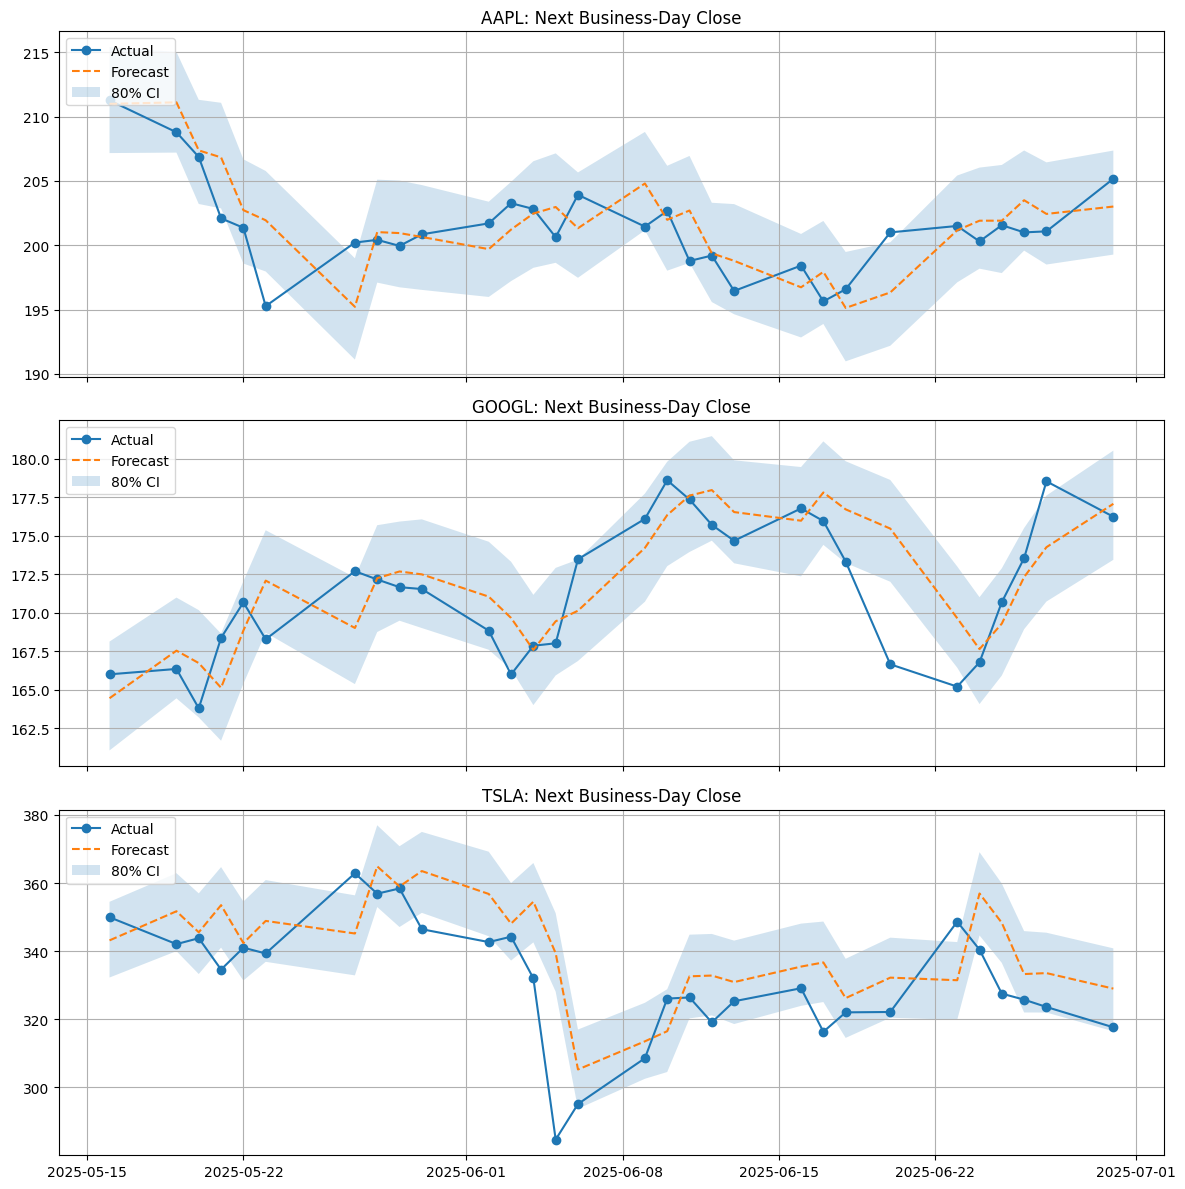

In [123]:
fig, axes = plt.subplots(len(tickers),1, figsize=(12,4*len(tickers)), sharex=True)
for ax, sym in zip(axes, tickers):
    test = test_dict[sym]
    fcst = fcst_dict[sym].loc[test.index]

    ax.plot(test.index, test["y"],   "-", marker="o", label="Actual")
    ax.plot(fcst.index, fcst["yhat"], "--", label="Forecast")
    ax.fill_between(
        fcst.index,
        fcst["yhat_lower"],
        fcst["yhat_upper"],
        alpha=0.2, label="80% CI"
    )
    ax.set_title(f"{sym}: Next Business-Day Close")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

16:38:17 - cmdstanpy - INFO - Chain [1] start processing




=== AAPL ===


16:38:18 - cmdstanpy - INFO - Chain [1] done processing
16:38:18 - cmdstanpy - INFO - Chain [1] start processing
16:38:18 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.361612,0.601342,0.546289,0.002434,0.002182,0.002433,0.750
1,4 days,0.931967,0.965384,0.886593,0.003889,0.003928,0.003881,0.500
2,5 days,0.990554,0.995266,0.939223,0.004258,0.004120,0.004249,0.625
3,6 days,1.278565,1.130737,1.097414,0.005127,0.005134,0.005113,0.500
4,7 days,1.039397,1.019508,0.973469,0.004526,0.004120,0.004515,0.625


/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



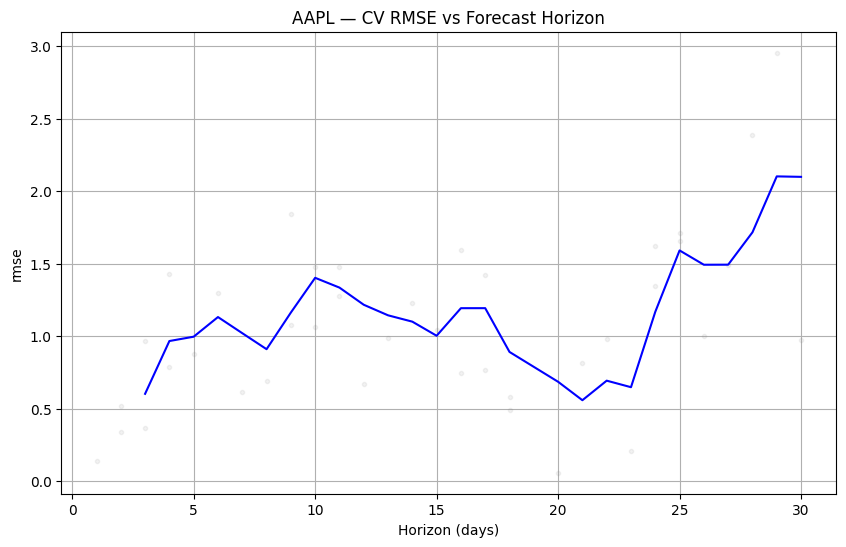

16:38:19 - cmdstanpy - INFO - Chain [1] start processing




=== GOOGL ===


16:38:19 - cmdstanpy - INFO - Chain [1] done processing
16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] start processing
16:38:20 - cmdstanpy - INFO - Chain [1] done processing
16:38:20 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.426044,0.652720,0.568729,0.003373,0.003378,0.003365,0.500
1,4 days,0.527378,0.726208,0.655232,0.003889,0.004247,0.003880,0.250
2,5 days,0.585157,0.764956,0.692931,0.004115,0.005319,0.004105,0.250
3,6 days,0.494050,0.702887,0.634675,0.003743,0.004122,0.003734,0.500
4,7 days,0.426580,0.653131,0.581781,0.003415,0.004122,0.003408,0.625


/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



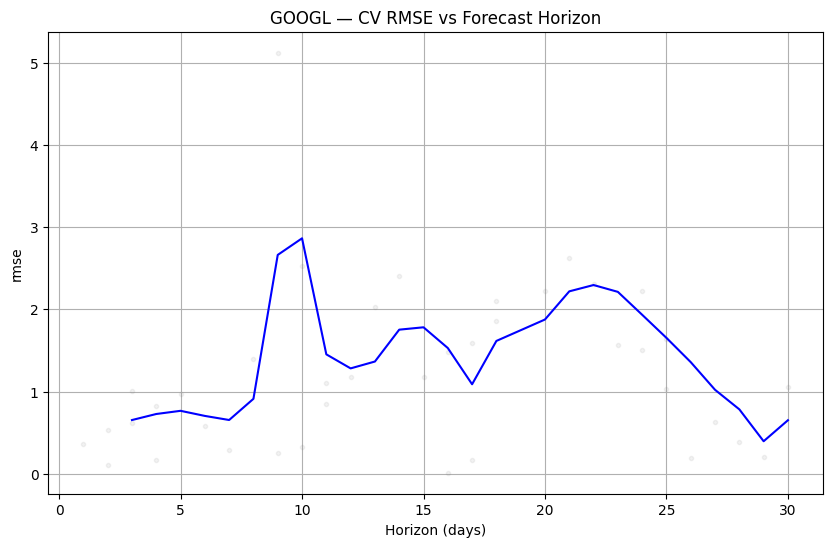

16:38:20 - cmdstanpy - INFO - Chain [1] start processing




=== TSLA ===


16:38:20 - cmdstanpy - INFO - Chain [1] done processing
16:38:20 - cmdstanpy - INFO - Chain [1] start processing
16:38:20 - cmdstanpy - INFO - Chain [1] start processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,3.835339,1.958402,1.685023,0.004837,0.004334,0.004843,0.750
1,4 days,8.942139,2.990341,2.428305,0.006582,0.004782,0.006603,0.750
2,5 days,9.211108,3.034981,2.521770,0.007169,0.006222,0.007187,0.750
3,6 days,18.511662,4.302518,3.715734,0.011426,0.010269,0.011390,0.500
4,7 days,15.018554,3.875378,3.176182,0.009969,0.005243,0.009921,0.625


/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/Users/mohitnotani/Desktop/Thesis/venv311/lib/python3.11/site-packages/prophet/plot.py:548: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



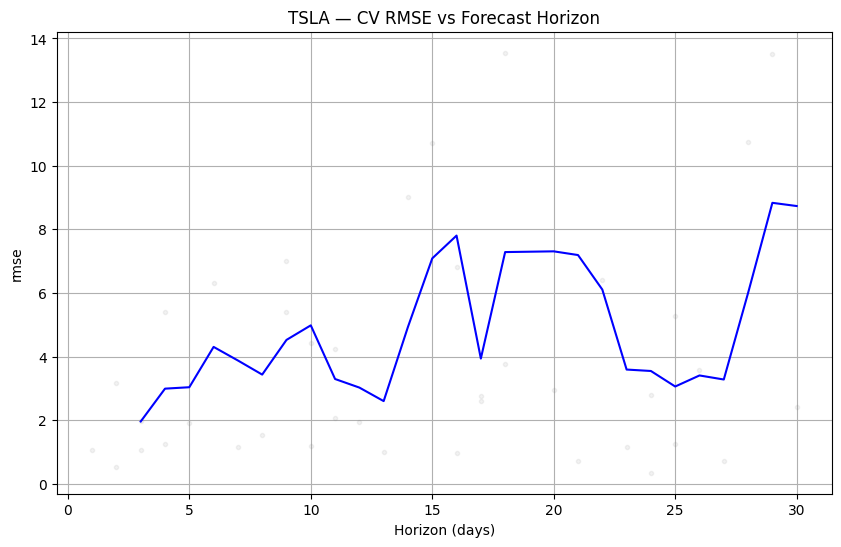

In [124]:
# In [ ]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

# 1) load & prep
df = pd.read_csv("../data/processed/features_stationary.csv", parse_dates=["Date"])
df = df.rename(columns={"Date":"ds","Close":"y"})
# drop rows with any NaNs in y or regressors
all_regs = [c for c in df.columns if c not in ("ds","Ticker","y")]
df = df.dropna(subset=["y"] + all_regs)

tickers = df["Ticker"].unique().tolist()

# 2) cross-validate per ticker
for sym in tickers:
    print(f"\n\n=== {sym} ===")
    df_sym = df[df["Ticker"]==sym].copy().reset_index(drop=True)
    
    # fit Prophet on full history
    m = Prophet(changepoint_prior_scale=0.5)  # more flexibility
    for r in all_regs:
        m.add_regressor(r)
    m.fit(df_sym)
    
    # roll-forward backtest
    #   initial: how much history before first fold
    #   period: how often to move your training window forward
    #   horizon: how far ahead to predict each fold
    df_cv = cross_validation(
        m,
        initial="700 days",
        period="180 days",
        horizon="30 days",
        parallel="threads"
    )
    
    # 3) aggregate metrics
    df_p = performance_metrics(df_cv)
    display(df_p.head())   # shows rmse, mae, mape, etc. at each horizon
    
    # 4) plot one of the metrics vs. forecast horizon
    fig = plot_cross_validation_metric(df_cv, metric="rmse")
    plt.title(f"{sym} — CV RMSE vs Forecast Horizon")
    plt.show()
